In [59]:
#preprocessing SANBS data

import pandas as pd
import numpy as np
import datetime as dt
from datetime import timedelta

import matplotlib.pyplot as plt
import seaborn as sns

df=pd.read_csv("../1_data/private/SANBSdata.csv", error_bad_lines=False)


c:\Users\jagir\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3165: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [60]:

#add a column OUTCOME_TYPE that indicates hgb deferal, other deferral or completed donation to indicate deferral type

df.loc[(df['Outcome'] == 'DEFERRAL') & (df["category"]=='Haematocrit/Haemoglobin'), 'OUTCOME_TYPE'] = 'low hgb'
df.loc[(df['Outcome'] == "SUCCESSFUL DONATION"), 'OUTCOME_TYPE'] = 'completed'
df.loc[(df['Outcome'] == "DEFERRAL") & (df["category"]!='Haematocrit/Haemoglobin') , 'OUTCOME_TYPE'] = 'other deferral'
df['OUTCOME_TYPE'].fillna("no draw", inplace=True)

df.drop(df[df['Visit_Date'].isna()].index, inplace=True) #remove any missing visit dates

df["Visit_Date"] = df["Visit_Date"].astype("datetime64") #convert to date time object

df.sort_values(by=['DonorID', 'don_Sequence', 'Visit_Date'], axis = 0, inplace=True)



In [61]:

#add censored column (indicates whether row is right censored) 0-censored, 1-notcensored
df['CENSORED']=np.where(df['DonorID'] == df['DonorID'].shift(-1), 1, 0)

#add time_to_return column (time between visits)
#if return exists -> difference between visit dates
#else difference between visit date and end of data collection 2022-12-31

df['time_to_return']= np.where(df['CENSORED']==1, (df['Visit_Date'].shift(-1)-df['Visit_Date'])/np.timedelta64(1, 'D'), (dt.datetime(2022, 12, 31)-df["Visit_Date"])/np.timedelta64(1, 'D'))
#df['time_to_return'].fillna((df['VISIT_DATE'].shift(-1)-df["VISIT_DATE"])/np.timedelta64(1, 'D'), inplace=True)

#remove permanent deferrals
df.drop(df[df.Deferral_permanent == 'Perm'].index, inplace=True)
df.drop(df[(df['OUTCOME_TYPE'] == 'other deferral') & (df['Deferral_permanent'] == 'NoDeferral')].index, inplace=True)




In [10]:
#compute time_to_return with shifts for completed donation: subtract 56 days 

df['time_to_return'] = np.where(df['OUTCOME_TYPE'] == 'completed', (df['time_to_return'] - 56), df['time_to_return'])

#compute time_to_return with shifts for other donations
#first covert eligibilty year and month to a datetime object

df["Def_end"] = df["Def_end"].astype("datetime64")


df['time_to_return'] = np.where(df['OUTCOME_TYPE'] == 'low hgb', (df['time_to_return'] - ((df['Def_end'] - df['Visit_Date'])/np.timedelta64(1, 'D'))), df['time_to_return'])

df['time_to_return'] = np.where(df['OUTCOME_TYPE'] == 'other deferral', (df['time_to_return'] - ((df['Def_end'] - df['Visit_Date'])/np.timedelta64(1, 'D'))), df['time_to_return'])
df['time_to_return'].isna().sum()

0

<AxesSubplot:xlabel='Fixed_mobile', ylabel='Probability'>

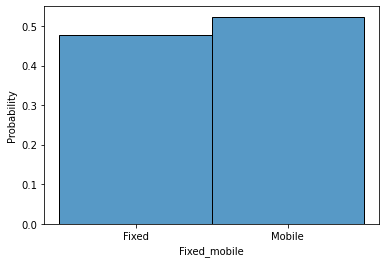

In [62]:
#Fixed-Mobile Donations Analysis

#plot number - mobile=0, fixed=1
fixed=df["Fixed"]
#sns.histplot(df, x="Fixed", stat="probability")
#sns.countplot(fixed)
#print(fixed.value_counts())

# group and remove some categories that are not fixed or mobile
# administrative site and apheresis clinic fall under fixed
# exclude others

df.drop(df[(df['Fixed']== 'Lapsed Clinic') | (df['Fixed']=='Processing Lab')| (df['Fixed']=='Unallocated') 
           | (df["Fixed"]== 'Laboratorium') |(df["Fixed"]=='Doctor')].index, inplace=True)

df['Fixed_mobile'] = np.where(df['Fixed'] == 'Mobile Clinic', 'Mobile', 'Fixed')
sns.histplot(df, x="Fixed_mobile", stat="probability")

#create a column to indicate 
    #1. mobile then mobile - mm
    #2. mobile then fixed -mf
    #3. fixed then fixed - ff
    #4. fixed then mobile - fm

df["FIXED_NEXT"] = np.where(df['DonorID'] == df['DonorID'].shift(-1), df['FIXED'].shift(-1), 10)
df.loc[((df['DonorID'] == df['DonorID'].shift(-1)) & (df['Fixed_mobile'] == 'Fixed') 
        & (df['Fixed_mobile']== 'Fixed')), 'fixed_mobile_pattern'] = 'FF'
df.loc[((df['DonorID'] == df['DonorID'].shift(-1)) & (df['Fixed_mobile'] == 'Mobile') 
        & (df['Fixed_mobile']== 'Mobile')), 'fixed_mobile_pattern']= 'MM'
df.loc[((df['DonorID'] == df['DonorID'].shift(-1)) & (df['Fixed_mobile'] == 'Fixed') 
        & (df['Fixed_mobile']== 'Mobile')), 'fixed_mobile_pattern'] = 'FM'
df.loc[((df['DonorID'] == df['DonorID'].shift(-1)) & (df['Fixed_mobile'] == 'Mobile') 
        & (df['Fixed_mobile']== 'Fixed')), 'fixed_mobile_pattern']= 'MF'
df['fixed_mobile_pattern'].fillna('last', inplace=True)

# percent population fixed vs mobile by year
# - do people go back to the same mobile site?
# - how many people never completed donation?


In [63]:
# Compute donation product for deferred donors - using the following criteria
 # - if donor only has WB then deferred donation is WB
 # - if next donation procedure is WB then deferred donation is WB
 # - if previous donation procedure is WB then deferred donation is WB


df['don_proc_imputed'] = np.where((df.Outcome=='DEFFERAL') & (df['DonorID'] == df['DonorID'].shift(1)) 
                                  & (df.donation_product.shift(1) == "WB"), 'WB', df['donation_product'])
    
df['don_proc_imputed'] = np.where((df.Outcome=='DEFFERAL') & (df['DonorID'] == df['DonorID'].shift(-1)) 
                                  & (df.donation_product.shift(-1) == "WB"), 'WB', df['donation_product'])

#df['don_proc_imputed']=np.where((df.Outcome=='DEFFERAL') ,'WB', df['donation_product'])

#df_group=df.groupby('DonorID')['donation_product']
#df2=df.loc[df['don_proc_imputed']=='DEF PROD']

#len(df2)

#df_group.head()


In [58]:
#a = df.groupby('DonorID').donation_product.nunique() ==1
#a[a].index.tolist()



,DonorID,Visit_Date,Visit_yr,Visit_Mo,donation_time,don_Sequence,col_Int,Visit_Age,sex,Fixed,...,Def_start,Def_end,Deferral_permanent,EffectiveYr,EffectiveMo,OUTCOME_TYPE,CENSORED,time_to_return,Fixed_mobile,don_proc_imputed
651015,18366,2020-12-12,2020.0,12.0,1129.0,25.0,7955.0,50.9,F,Fixed Clinic,...,NaN,NaT,NoDeferral,NaN,NaN,completed,1,16.0,Fixed,WB
2808706,18366,2021-02-22,2021.0,2.0,1006.0,26.0,72.0,51.1,F,Fixed Clinic,...,NaN,NaT,NoDeferral,NaN,NaN,completed,1,180.0,Fixed,WB
4752075,18366,2021-10-16,2021.0,10.0,1133.0,27.0,236.0,51.8,F,Fixed Clinic,...,NaN,NaT,NoDeferral,NaN,NaN,completed,0,385.0,Fixed,WB


In [49]:
# documenting some errors in data

df['time_to_return'].isnull().sum()

df_end=df.loc[df['Visit_Date'] > df['Def_end']]
#print(len(df_end))
#df_end.head(25).to_csv('../4_output/def_end_error.csv')

df_def=df.loc[(df['Deferral_permanent'] == 'NoDeferral') & (df['OUTCOME_TYPE'] == "other deferral")]
#df_def.head(25).to_csv('../4_output/def_permanent_error.csv')

#df_neg=df.loc[ (df['time_to_return']<0)]

#print(len(df_neg))
#df_neg.head(-25)

In [64]:
df.to_csv(("../1_data/private/preprocessed_data.csv"), index=False)
